Epoch [1/10], Loss: 0.0518
Epoch [2/10], Loss: 0.0450
Epoch [3/10], Loss: 0.0386
Epoch [4/10], Loss: 0.0359
Epoch [5/10], Loss: 0.0382
Epoch [6/10], Loss: 0.0306
Epoch [7/10], Loss: 0.0358
Epoch [8/10], Loss: 0.0346
Epoch [9/10], Loss: 0.0360
Epoch [10/10], Loss: 0.0346


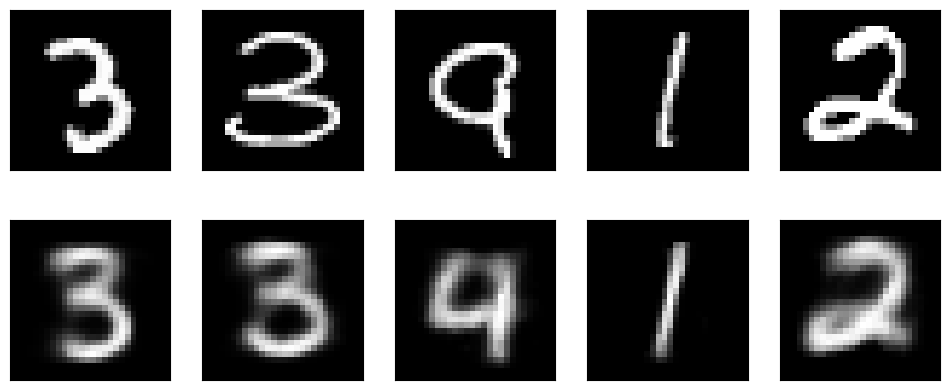

In [4]:
# Using autoencoders for denoising images example

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
num_epochs = 10
batch_size = 64
learning_rate = 1e-3

# MNIST dataset
dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Autoencoder Model
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 12),
            nn.ReLU(),
            nn.Linear(12, 3))

        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.ReLU(),
            nn.Linear(12, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28*28),
            nn.Sigmoid())

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

model = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    for data in dataloader:
        img, _ = data
        img = img.view(img.size(0), -1).to(device)
        
        # Forward pass
        outputs = model(img)
        loss = criterion(outputs, img)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

dataiter = iter(dataloader)
images, labels = next(dataiter)
images = images.view(images.size(0), -1).to(device)
outputs = model(images)
outputs = outputs.view(batch_size, 1, 28, 28).cpu().data

fig, axes = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True, figsize=(12,5))
for images, row in zip([images[:5], outputs[:5]], axes):
    for img, ax in zip(images, row):
        ax.imshow(img.reshape((28,28)), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
plt.show()


[*********************100%%**********************]  1 of 1 completed


Epoch 1, Loss: 0.5322228670120239
Epoch 11, Loss: 0.30364519357681274
Epoch 21, Loss: 0.08878567069768906
Epoch 31, Loss: 0.04582471773028374
Epoch 41, Loss: 0.043873485177755356
Epoch 51, Loss: 0.033403873443603516
Epoch 61, Loss: 0.022660262882709503
Epoch 71, Loss: 0.015248888172209263
Epoch 81, Loss: 0.010625345632433891
Epoch 91, Loss: 0.007106720469892025
Epoch 101, Loss: 0.004529333207756281
Epoch 111, Loss: 0.00288987485691905
Epoch 121, Loss: 0.002413269132375717
Epoch 131, Loss: 0.002308203373104334
Epoch 141, Loss: 0.0021470393985509872
Epoch 151, Loss: 0.002027128590270877
Epoch 161, Loss: 0.0020642089657485485
Epoch 171, Loss: 0.0018722715321928263
Epoch 181, Loss: 0.0017845983384177089
Epoch 191, Loss: 0.0017128539038822055


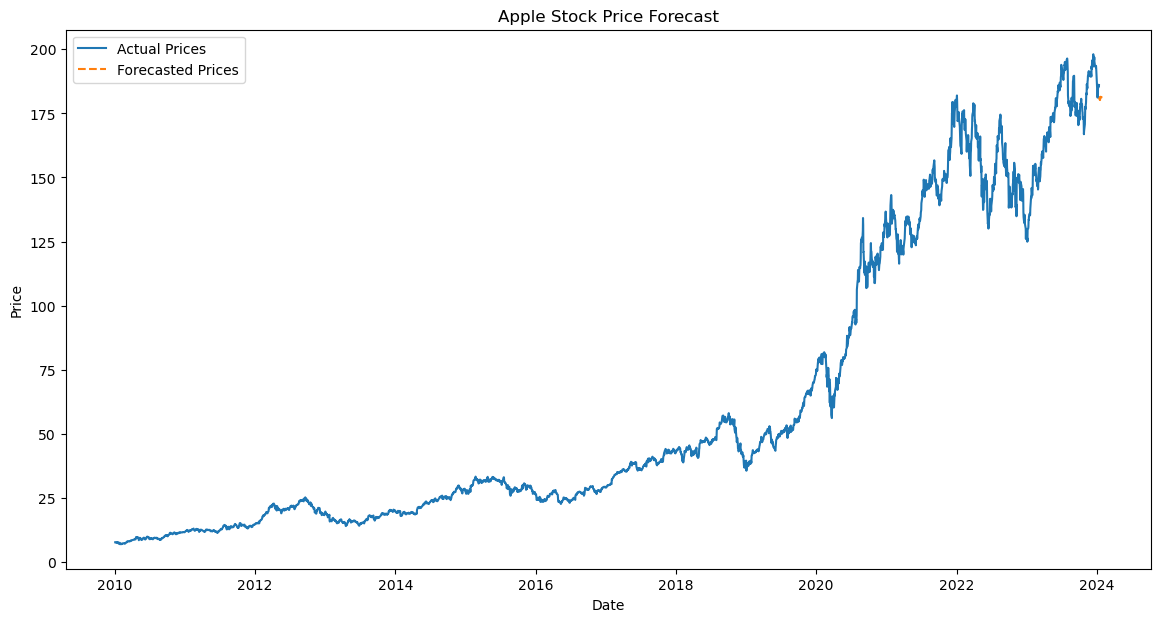

In [7]:
# Plot previous prices as well as forecast

# TTF M+1, power market month + 1
# Sharpe Ratio
# Focus on the target itself

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
import yfinance as yf
import matplotlib.pyplot as plt

# We use yfinance to get the stock price history of Apple
aapl_df = yf.download('AAPL', start='2010-01-01', end='2024-01-15')

# Normalize the data
close_prices = aapl_df[['Close']].values
scaler = MinMaxScaler(feature_range=(-1, 1))
data_normalized = scaler.fit_transform(close_prices)


def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data)-seq_length-1):
        x = data[i:(i+seq_length), 0]
        y = data[i+seq_length, 0]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 21
X, y = create_sequences(data_normalized, seq_length)
X = torch.from_numpy(X).float()
y = torch.from_numpy(y).float().view(-1, 1)

forecast_timeframe = 14

class Autoencoder(nn.Module):
    def __init__(self, seq_length):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(seq_length, 128),
            nn.Tanh(),
            nn.Linear(128, 64),
            nn.Tanh(),
            nn.Linear(64, 12),
            nn.Tanh(),
            nn.Linear(12, 3)
        )
        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.Tanh(),
            nn.Linear(12, 64),
            nn.Tanh(),
            nn.Linear(64, 128),
            nn.Tanh(),
            nn.Linear(128, seq_length),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

model = Autoencoder(seq_length)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the autoencoder
epochs = 200
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    output = model(X)
    loss = criterion(output, X)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f'Epoch {epoch+1}, Loss: {loss.item()}')

# Forecasting for the specific timeframe
last_sequence = data_normalized[-seq_length:]
last_sequence = torch.from_numpy(last_sequence).float()
model.eval()
with torch.no_grad():
    predicted_normalized = model(last_sequence.view(1, seq_length)).numpy()
predicted_prices = scaler.inverse_transform(predicted_normalized.reshape(-1, 1)).flatten()

plt.figure(figsize=(14, 7))
plt.plot(aapl_df.index, aapl_df['Close'], label='Actual Prices')

# Forecasted prices
forecast_dates = pd.date_range(start=aapl_df.index[-1], periods=forecast_timeframe + 1)[1:]
plt.plot(forecast_dates, predicted_prices[:forecast_timeframe], label='Forecasted Prices', linestyle='--')

plt.legend()
plt.title('Apple Stock Price Forecast')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()


In [ ]:
# Only plot 3 day forecast
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
import yfinance as yf
import matplotlib.pyplot as plt

# Download the past 5 years of daily Apple stock prices
aapl_df = yf.download('AAPL', start='2019-03-15', end='2024-03-15')

# Normalize the prices
close_prices = aapl_df[['Close']].values
scaler = MinMaxScaler(feature_range=(-1, 1))
data_normalized = scaler.fit_transform(close_prices)

# Creating sequences for training
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data)-seq_length-1):
        x = data[i:(i+seq_length), 0]
        y = data[i+seq_length, 0]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 10  # Number of days to look back
X, y = create_sequences(data_normalized, seq_length)
X = torch.from_numpy(X).float()
y = torch.from_numpy(y).float().view(-1, 1)  # Reshape y to [batch_size, 1] for consistency

# Building and Training the Autoencoder
class Autoencoder(nn.Module):
    def __init__(self, seq_length):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(seq_length, 128),
            nn.Tanh(),
            nn.Linear(128, 64),
            nn.Tanh(),
            nn.Linear(64, 12),
            nn.Tanh(),
            nn.Linear(12, 3)  # compressing to 3-dimensional latent space
        )
        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.Tanh(),
            nn.Linear(12, 64),
            nn.Tanh(),
            nn.Linear(64, 128),
            nn.Tanh(),
            nn.Linear(128, seq_length),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

model = Autoencoder(seq_length)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the model
epochs = 100
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    output = model(X)
    loss = criterion(output, X)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f'Epoch {epoch+1}, Loss: {loss.item()}')

# Forecasting the Next Three Days
last_sequence = data_normalized[-seq_length:]
last_sequence = torch.from_numpy(last_sequence).float()
model.eval()
with torch.no_grad():
    predicted_normalized = model(last_sequence.view(1, seq_length)).numpy()
predicted_prices = scaler.inverse_transform(predicted_normalized.reshape(-1, 1)).flatten()

# Plotting the forecast with the actual prices
plt.figure(figsize=(10,6))
predicted_days = np.arange(1, 4, 1)
plt.plot(predicted_days, predicted_prices[:3], label='Forecasted Price')
plt.legend()
plt.title('Apple Stock Price Forecast')
plt.xlabel('Days')
plt.ylabel('Price')
plt.show()


In [ ]:
# Plot 7 day forecast

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
import yfinance as yf
import matplotlib.pyplot as plt

# Download the past 5 years of daily Apple stock prices
aapl_df = yf.download('AAPL', start='2019-03-15', end='2024-03-15')

# Normalize the prices
close_prices = aapl_df[['Close']].values
scaler = MinMaxScaler(feature_range=(-1, 1))
data_normalized = scaler.fit_transform(close_prices)

# Creating sequences for training
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data)-seq_length-1):
        x = data[i:(i+seq_length), 0]
        y = data[i+seq_length, 0]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 10  # Number of days to look back
X, y = create_sequences(data_normalized, seq_length)
X = torch.from_numpy(X).float()
y = torch.from_numpy(y).float().view(-1, 1)  # Reshape y to [batch_size, 1] for consistency

# Set the forecast timeframe
forecast_timeframe = 7

# Building and Training the Autoencoder
class Autoencoder(nn.Module):
    def __init__(self, seq_length):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(seq_length, 128),
            nn.Tanh(),
            nn.Linear(128, 64),
            nn.Tanh(),
            nn.Linear(64, 12),
            nn.Tanh(),
            nn.Linear(12, 3)  # compressing to 3-dimensional latent space
        )
        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.Tanh(),
            nn.Linear(12, 64),
            nn.Tanh(),
            nn.Linear(64, 128),
            nn.Tanh(),
            nn.Linear(128, seq_length),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

model = Autoencoder(seq_length)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the model
epochs = 100
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    output = model(X)
    loss = criterion(output, X)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f'Epoch {epoch+1}, Loss: {loss.item()}')

# Forecasting the Next 'forecast_timeframe' Days
last_sequence = data_normalized[-seq_length:]
last_sequence = torch.from_numpy(last_sequence).float()
model.eval()
with torch.no_grad():
    predicted_normalized = model(last_sequence.view(1, seq_length)).numpy()
predicted_prices = scaler.inverse_transform(predicted_normalized.reshape(-1, 1)).flatten()

# Plotting the forecast with the actual prices
plt.figure(figsize=(10,6))
predicted_days = np.arange(1, forecast_timeframe + 1, 1)  # Adjusted for forecast_timeframe
plt.plot(predicted_days, predicted_prices[:forecast_timeframe], label='Forecasted Price')  # Adjusted for forecast_timeframe
plt.legend()
plt.title('Apple Stock Price Forecast')
plt.xlabel('Days')
plt.ylabel('Price')
plt.show()


In [ ]:
# Plot previous prices as well as forecast

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
import yfinance as yf
import matplotlib.pyplot as plt

# We use yfinance to get the stock price history of Apple
aapl_df = yf.download('AAPL', start='2010-01-01', end='2024-01-15')

# Normalize the data
close_prices = aapl_df[['Close']].values
scaler = MinMaxScaler(feature_range=(-1, 1))
data_normalized = scaler.fit_transform(close_prices)


def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data)-seq_length-1):
        x = data[i:(i+seq_length), 0]
        y = data[i+seq_length, 0]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 21
X, y = create_sequences(data_normalized, seq_length)
X = torch.from_numpy(X).float()
y = torch.from_numpy(y).float().view(-1, 1)

forecast_timeframe = 14

class Autoencoder(nn.Module):
    def __init__(self, seq_length):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(seq_length, 128),
            nn.Tanh(),
            nn.Linear(128, 64),
            nn.Tanh(),
            nn.Linear(64, 12),
            nn.Tanh(),
            nn.Linear(12, 3)
        )
        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.Tanh(),
            nn.Linear(12, 64),
            nn.Tanh(),
            nn.Linear(64, 128),
            nn.Tanh(),
            nn.Linear(128, seq_length),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

model = Autoencoder(seq_length)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the autoencoder
epochs = 200
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    output = model(X)
    loss = criterion(output, X)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f'Epoch {epoch+1}, Loss: {loss.item()}')

# Forecasting for the specific timeframe
last_sequence = data_normalized[-seq_length:]
last_sequence = torch.from_numpy(last_sequence).float()
model.eval()
with torch.no_grad():
    predicted_normalized = model(last_sequence.view(1, seq_length)).numpy()
predicted_prices = scaler.inverse_transform(predicted_normalized.reshape(-1, 1)).flatten()

plt.figure(figsize=(14, 7))
plt.plot(aapl_df.index, aapl_df['Close'], label='Actual Prices')

# Forecasted prices
forecast_dates = pd.date_range(start=aapl_df.index[-1], periods=forecast_timeframe + 1)[1:]
plt.plot(forecast_dates, predicted_prices[:forecast_timeframe], label='Forecasted Prices', linestyle='--')

plt.legend()
plt.title('Apple Stock Price Forecast')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()


In [ ]:
# Plot forecast compared to actual prices -> High overfitting

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
import yfinance as yf
import matplotlib.pyplot as plt

# Download the past 5 years of daily Apple stock prices
aapl_df = yf.download('AAPL', start='2010-01-01', end='2024-03-15')  # Adjusted timeframe

# Normalize the prices
close_prices = aapl_df[['Close']].values
scaler = MinMaxScaler(feature_range=(-1, 1))
data_normalized = scaler.fit_transform(close_prices)

# Creating sequences for training
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data)-seq_length-1):
        x = data[i:(i+seq_length), 0]
        y = data[i+seq_length, 0]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 21  # Number of days to look back
X, y = create_sequences(data_normalized, seq_length)
X = torch.from_numpy(X).float()
y = torch.from_numpy(y).float().view(-1, 1)  # Reshape y to [batch_size, 1] for consistency

# Building and Training the Autoencoder
class Autoencoder(nn.Module):
    def __init__(self, seq_length):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(seq_length, 128),
            nn.Tanh(),
            nn.Linear(128, 64),
            nn.Tanh(),
            nn.Linear(64, 12),
            nn.Tanh(),
            nn.Linear(12, 3)  # compressing to 3-dimensional latent space
        )
        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.Tanh(),
            nn.Linear(12, 64),
            nn.Tanh(),
            nn.Linear(64, 128),
            nn.Tanh(),
            nn.Linear(128, seq_length),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

model = Autoencoder(seq_length)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the model (this code is provided for completeness; training should occur with the actual data)
epochs = 200
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    output = model(X)
    loss = criterion(output, X)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f'Epoch {epoch+1}, Loss: {loss.item()}')

# Function to perform a single forecast step
def forecast_one_step(model, last_sequence, scaler):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        last_sequence_tensor = torch.FloatTensor(last_sequence).view(1, -1)
        predicted_normalized = model(last_sequence_tensor).numpy()
    predicted_prices = scaler.inverse_transform(predicted_normalized.reshape(-1, 1)).flatten()
    return predicted_prices

# Initialize an empty DataFrame to hold forecasts
forecasts_df = pd.DataFrame(index=aapl_df.index, columns=['Forecast'])
forecasts_df['Forecast'] = np.nan  # Initialize with NaNs

# Perform a rolling forecast starting from 2021
forecast_dates = pd.date_range(start='2021-01-01', end=aapl_df.index[-1])

for forecast_date in forecast_dates:
    if forecast_date in aapl_df.index:
        forecast_idx = aapl_df.index.get_loc(forecast_date)
        if forecast_idx >= seq_length:
            last_sequence = data_normalized[forecast_idx-seq_length:forecast_idx]
            forecasted_price = forecast_one_step(model, last_sequence, scaler)
            forecasts_df.loc[forecast_date, 'Forecast'] = forecasted_price[0]

# Convert forecasts to numeric values where available
forecasts_df['Forecast'] = pd.to_numeric(forecasts_df['Forecast'], errors='coerce')

# Plot the actual prices and the rolling forecasts
plt.figure(figsize=(14, 7))
plt.plot(aapl_df.index, aapl_df['Close'], label='Actual Prices')
plt.plot(forecasts_df.index, forecasts_df['Forecast'], label='Forecasted Prices', linestyle='--')

# Plot legend, title, and labels
plt.legend()
plt.title('Apple Stock Price Forecast vs Actual Prices Since 2021')
plt.xlabel('Date')
plt.ylabel


In [1]:
# Using Training and Testing Set
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import yfinance as yf
import matplotlib.pyplot as plt

# Download daily Apple stock prices
aapl_df = yf.download('AAPL', start='2010-01-01', end='2024-01-15')

# Split the data into training and testing sets
split_date = '2022-12-31'
train_data = aapl_df['Close'][:split_date].values
test_data = aapl_df['Close'][split_date:].values

# Normalize the training data
scaler = MinMaxScaler(feature_range=(-1, 1))
train_normalized = scaler.fit_transform(train_data.reshape(-1, 1))

# Normalize the test data using the scaler fitted on the training data
test_normalized = scaler.transform(test_data.reshape(-1, 1))

# Creating sequences for training
seq_length = 21

# Define the create_sequences function
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data)-seq_length):
        x = data[i:(i+seq_length)]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# Define the Autoencoder model class
class Autoencoder(nn.Module):
    def __init__(self, seq_length):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(seq_length, 128),
            nn.Tanh(),
            nn.Linear(128, 64),
            nn.Tanh(),
            nn.Linear(64, 12),
            nn.Tanh(),
            nn.Linear(12, 3)  # Compressing to a 3-dimensional latent space
        )
        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.Tanh(),
            nn.Linear(12, 64),
            nn.Tanh(),
            nn.Linear(64, 128),
            nn.Tanh(),
            nn.Linear(128, seq_length)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        # If y_train is just the next value, we need to match that in the output
        return x[:, -1] 

# Create sequences from the normalized training data
X_train, y_train = create_sequences(train_normalized, seq_length)
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()

# Instantiate the model
model = Autoencoder(seq_length)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
epochs = 200
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()

    # Forward pass
    output = model(X_train)
    loss = criterion(output, y_train)
    
    # Backward pass and optimization
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:
        print(f'Epoch {epoch+1}, Loss: {loss.item()}')

# Function to perform a single forecast step
def forecast_one_step(model, last_sequence, scaler):
    model.eval()
    with torch.no_grad():
        last_sequence_tensor = torch.FloatTensor(last_sequence).view(1, -1)
        predicted_normalized = model(last_sequence_tensor).numpy()
    predicted_prices = scaler.inverse_transform(predicted_normalized.reshape(-1, 1)).flatten()
    return predicted_prices

# Forecast on the test data
test_predictions = []
for i in range(len(test_normalized) - seq_length):
    last_sequence = test_normalized[i:i+seq_length]
    test_predictions.append(forecast_one_step(model, last_sequence, scaler)[0])

# Calculate test error
test_mse = mean_squared_error(test_data[seq_length:], test_predictions)
print(f'Test MSE: {test_mse}')

# Plot the actual prices and the rolling forecasts for the test set
test_dates = pd.to_datetime(aapl_df.index)[len(train_data) + seq_length:]
plt.figure(figsize=(14, 7))
plt.plot(test_dates, test_data[seq_length:], label='Actual Prices')
plt.plot(test_dates, test_predictions, label='Forecasted Prices', linestyle='--')
plt.legend()
plt.title('Model Test Performance')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


[*********************100%%**********************]  1 of 1 completed


RuntimeError: mat1 and mat2 shapes cannot be multiplied (68271x1 and 21x128)

Epoch [1/10], Loss: 0.0505
Epoch [2/10], Loss: 0.0435
Epoch [3/10], Loss: 0.0399
Epoch [4/10], Loss: 0.0407
Epoch [5/10], Loss: 0.0344
Epoch [6/10], Loss: 0.0372
Epoch [7/10], Loss: 0.0371
Epoch [8/10], Loss: 0.0322
Epoch [9/10], Loss: 0.0319
Epoch [10/10], Loss: 0.0349


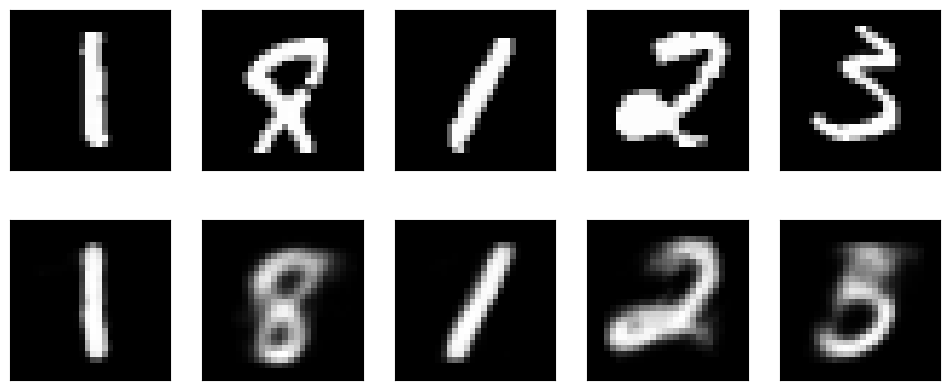